# Epidemiology Final — Measles (SIR → SIRS → SIRS + Migration)

Time unit: **weeks**. This notebook reproduces SIR, extends to SIRS (waning + vaccination), and then adds **vital dynamics, disease mortality, seasonal forcing, and migration/importation**. Parameters are set to measles-like values.

**How to use**: Run top-to-bottom. Use the *Parameters* cell to tweak scenarios. Figures are shown inline; you can also save images by uncommenting `savefig(...)` lines.

## 1. Imports & helpers

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def savefig(path):
    plt.tight_layout(); plt.savefig(path, dpi=200); plt.show()

## 2. Transmission β(t) with seasonality

In [2]:
def beta_t(t, beta0, seasonal_amp=0.0, seasonal_T=52.0):
    """Sinusoidal seasonality: beta(t) = beta0 * (1 + a * sin(2π t / T))."""
    if seasonal_amp == 0.0:
        return beta0
    return beta0 * (1.0 + seasonal_amp * np.sin(2.0*np.pi*t/seasonal_T))

def beta_t_termtime(t, beta0, b1=0.25, T=52.0, term_weeks=39.0):
    """Term-time (school) forcing with mean-preserving high/low segments."""
    p = term_weeks / T
    b_high = b1
    b_low  = - (p / (1.0 - p)) * b1
    in_term = (t % T) < term_weeks
    factor = 1.0 + (b_high if in_term else b_low)
    return beta0 * factor

## 3. Models (proportions and counts)

In [3]:
def sir_rhs(y, t, beta0, gamma):
    S, I, R = y
    dSdt = -beta0 * S * I
    dIdt =  beta0 * S * I - gamma * I
    dRdt =  gamma * I
    return [dSdt, dIdt, dRdt]

def sirs_rhs(y, t, beta0, gamma, lam, nu=0.0, seasonal_amp=0.0, seasonal_T=52.0):
    S, I, R = y
    b = beta_t(t, beta0, seasonal_amp, seasonal_T)
    dSdt = -b * S * I - nu * S + lam * R
    dIdt =  b * S * I - gamma * I
    dRdt =  gamma * I + nu * S - lam * R
    return [dSdt, dIdt, dRdt]

def sirs_rhs_migration(y, t,
                       beta0, gamma, lam, nu,
                       seasonal_amp=0.0, seasonal_T=52.0,
                       Lambda=0.0, mu=0.0, delta=0.0,
                       MS_in=0.0, MS_out=0.0,
                       MI_in=0.0, MI_out=0.0,
                       MR_in=0.0, MR_out=0.0,
                       phi_I_func=None,
                       coverage=0.0):
    """Extended SIRS (COUNTS) with demography, disease mortality, seasonality, importation, and birth vaccination coverage.
    coverage: fraction of newborns vaccinated-at-birth (sent to R instead of S).
    """
    S, I, R = y
    N = max(S + I + R, 1e-12)
    b = beta_t(t, beta0, seasonal_amp, seasonal_T)
    Phi_I = 0.0 if phi_I_func is None else float(phi_I_func(t))
    # Vaccination at birth split
    Lambda_S = (1.0 - coverage) * Lambda
    Lambda_R = coverage * Lambda

    dSdt = (Lambda_S - mu*S - b*(S*I)/N - nu*S + lam*R + MS_in - MS_out)
    dIdt = (b*(S*I)/N - (gamma + mu + delta)*I + Phi_I + MI_in - MI_out)
    dRdt = (gamma*I - mu*R - lam*R + nu*S + Lambda_R + MR_in - MR_out)
    return [dSdt, dIdt, dRdt]

## 4. Parameters (Measles-like, weeks)

In [23]:
# Time grid (weeks)
t_max = 520  # 10 years
t = np.linspace(0, t_max, 5201)

# Epidemiology (measles-like)
gamma = 1.0               # recovery ~ 1 week infectious period
R0_target = 15.0          # measles ~ 12–18
beta0 = R0_target * gamma # baseline transmission

# Waning immunity (include small rate to demonstrate SIRS)
lam = 1.0 / (5.0 * 52.0)  # ~ 5 years

# Vaccination
coverage = 0.9126         # fraction of newborns vaccinated at birth (MMR coverage)
nu = 0.005                # small catch-up vaccination rate (per week)

# Demography & disease mortality
mu = 1.0 / (70.0 * 52.0)  # ~70-year life expectancy
delta = 0.0002            # disease-induced mortality in I (per week)

# Seasonality
seasonal_amp = 0.12       # sinusoidal forcing amplitude
seasonal_T = 52.0         # annual period

# Initial population (counts)
S0c, I0c, R0c = 9.9e5, 100.0, 0.0
N_star = S0c + I0c + R0c
Lambda = mu * N_star      # births chosen to balance deaths on average

# Importation (travel/migration) — trickle + pulses
eta_I = 0.05
def phi_I_combined(ti):
    pulse = 50.0 if abs(ti-130)<0.5 or abs(ti-390)<0.5 else 0.0  # pulses ~ years 2.5 & 7.5
    return eta_I + pulse

print(f"R0 target: {R0_target:.1f} → beta0={beta0:.2f}, gamma={gamma:.2f}")

R0 target: 15.0 → beta0=15.00, gamma=1.00


## 5. Baselines: SIR and SIRS (proportions)

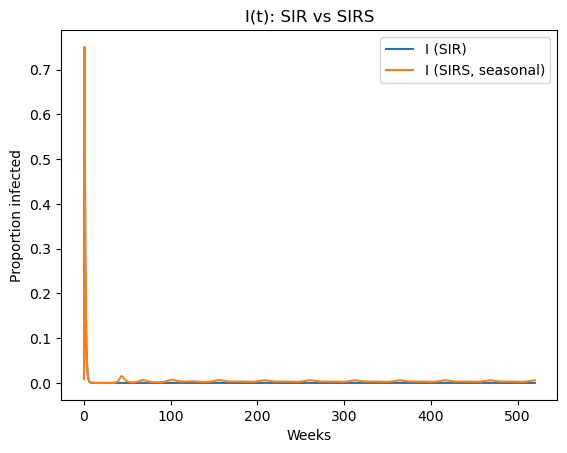

In [24]:
S0p, I0p, R0p = 0.99, 0.01, 0.0
sol_sir = odeint(sir_rhs, [S0p, I0p, R0p], t, args=(beta0, gamma))
sol_sirs = odeint(sirs_rhs, [S0p, I0p, R0p], t, args=(beta0, gamma, lam, 0.0, seasonal_amp, seasonal_T))
plt.figure();
plt.plot(t, sol_sir[:,1], label='I (SIR)');
plt.plot(t, sol_sirs[:,1], label='I (SIRS, seasonal)');
plt.xlabel('Weeks'); plt.ylabel('Proportion infected'); plt.title('I(t): SIR vs SIRS'); plt.legend(); plt.show()

## 6. Expanded model (counts): demography + mortality + coverage + seasonality + importation

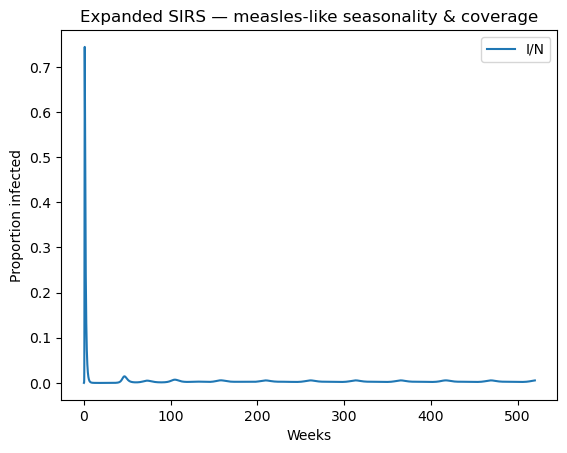

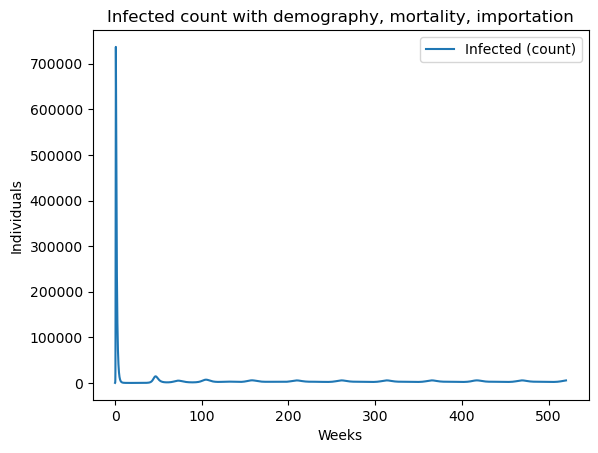

In [25]:
y0c = [S0c, I0c, R0c]
sol_ext = odeint(
    sirs_rhs_migration, y0c, t,
    args=(beta0, gamma, lam, nu,
          seasonal_amp, seasonal_T,
          Lambda, mu, delta,
          0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
          phi_I_combined,
          coverage)
)
S_c, I_c, R_c = sol_ext.T
N_c = S_c + I_c + R_c
Sp, Ip, Rp = S_c/N_c, I_c/N_c, R_c/N_c

plt.figure();
plt.plot(t, Ip, label='I/N'); plt.xlabel('Weeks'); plt.ylabel('Proportion infected');
plt.title('Expanded SIRS — measles-like seasonality & coverage'); plt.legend(); plt.show()

plt.figure();
plt.plot(t, I_c, label='Infected (count)'); plt.xlabel('Weeks'); plt.ylabel('Individuals');
plt.title('Infected count with demography, mortality, importation'); plt.legend(); plt.show()

## 7. Vaccination coverage sweep (peak I vs coverage)

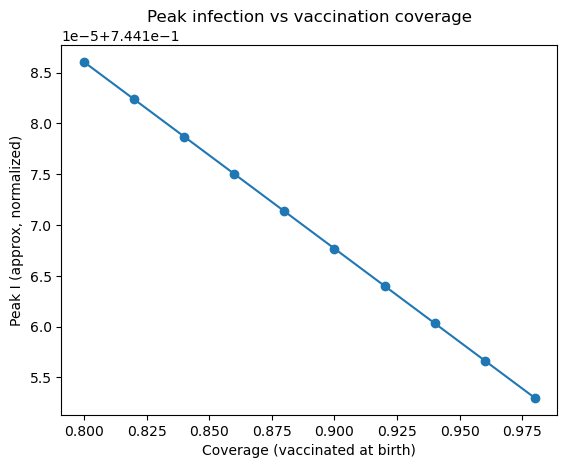

In [26]:
coverages = np.linspace(0.80, 0.98, 10)
peaks = []
for cov in coverages:
    sol_tmp = odeint(sirs_rhs_migration, y0c, t,
        args=(beta0, gamma, lam, nu, seasonal_amp, seasonal_T,
              Lambda, mu, delta, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
              phi_I_combined, cov))
    peaks.append(sol_tmp[:,1].max() / (sol_tmp.sum(axis=1).max()))  # rough normalized peak
plt.figure();
plt.plot(coverages, peaks, marker='o'); plt.xlabel('Coverage (vaccinated at birth)'); plt.ylabel('Peak I (approx, normalized)');
plt.title('Peak infection vs vaccination coverage'); plt.show()

## 8. Inline summary

In [27]:
peak_I = float(np.max(I_c))
t_peak = float(t[np.argmax(I_c)])
print('---- Summary (Expanded SIRS) ----')
print(f'R0 (baseline) ≈ {beta0/gamma:.1f}')
print(f'Peak infected (count): {peak_I:,.0f} at week {t_peak:.1f}')
print(f'Final proportions: S={Sp[-1]:.4f}, I={Ip[-1]:.4f}, R={Rp[-1]:.4f}')
print(f'coverage={coverage:.4f}, nu={nu:.4f}/wk, lam={lam:.5f}/wk, seasonal_amp={seasonal_amp}')

---- Summary (Expanded SIRS) ----
R0 (baseline) ≈ 15.0
Peak infected (count): 736,798 at week 0.9
Final proportions: S=0.0685, I=0.0055, R=0.9260
coverage=0.9126, nu=0.0050/wk, lam=0.00385/wk, seasonal_amp=0.12
